# UJIIndoorLoc Response EDA and Classification - Part 2

In the [previous notebook](#UJIIndoorLoc-preprocess.ipynb), we performed various transformations on the independent variables of the raw UJIIndoorLoc dataset to prepare it for the machine learning. 

In this notebook, first, I focus on our response variables including building ID, floor ID, latitiude and longitude. Understanding the class imbalance in classification responses buildingID and floorID is important for training our machine learning models. Similarly, I analyze the distributions of our regression response variables latitude and longitude and their relationship with the building ID and floor ID. Second, I formulate the localization problem for the machine learning. Finally, I begin constructing machine learning framework with the model selection and evaluation for building classification.

## Table of Contents

1. [Setup](#setup)

2. [Response EDA](#response-eda)

3. [Problem Formulation](#problem-formulation)

4. [Building Classification](#building-classification)

5. [Floor Classification](#floor-classification)
                
6. [Conclusion](#conclusion)

<p><a name="setup"></a></p>

## 1. Setup

In [11]:
# Data Collection and Transformations
import numpy as np
import pandas as pd
import datetime as dt
import time
import pickle
from sklearn.preprocessing import Imputer, StandardScaler

# Statistical Testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, classification_report

# Class imbalance 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
%matplotlib inline

import warnings

Loading the transformed data from our previous notebook.

In [4]:
pkl_file = open('data_after_PCA.pckl', 'rb')

X_train_pca = pickle.load(pkl_file)
y_train = pickle.load(pkl_file)
X_test_pca = pickle.load(pkl_file)
y_test = pickle.load(pkl_file)

X_train_pca.shape,y_train.shape,X_test_pca.shape,y_test.shape

((19861, 150), (19861, 6), (1111, 150), (1111, 6))

<p><a name="building-eda"></a></p>

In [8]:
y_train.head()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION
0,-7541.2643,4.864921e+06,2,1,106,2
1,-7536.6212,4.864934e+06,2,1,106,2
2,-7519.1524,4.864950e+06,2,1,103,2
3,-7524.5704,4.864934e+06,2,1,102,2
5,-7533.8962,4.864939e+06,2,1,105,2


In the next few sections, we explore the characteristics of the different response variables.

<p><a name="response-eda"></a></p>

## 2. Response EDA

### 2.1 Building EDA

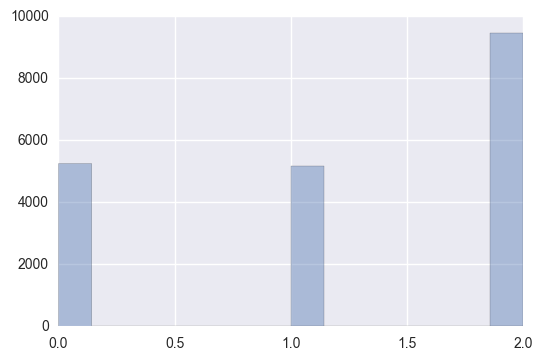

In [10]:
sns.distplot(y_train[['BUILDINGID']],kde=False)

*Observations*:

1. In our training samples, building 2 has the clear majority with it's count being slightly lower than the sum of building 0 and building 1.

2. Building 0 and building 1 have roughly the same representation in the training data.

Clearly, there is an imbalance among the groups.

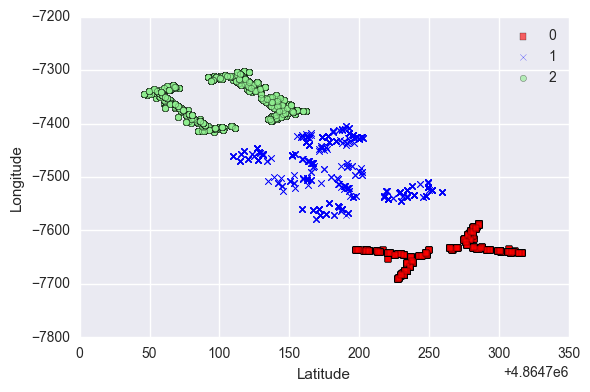

In [22]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_train['BUILDINGID']))])

for idx, cl in enumerate(np.unique(y_train['BUILDINGID'])):
        plt.scatter(x=y_train.loc[y_train.BUILDINGID== cl]['LATITUDE'], 
                    y=y_train.loc[y_train.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()

The above plot illustrates the locations of the buildings in the campus.

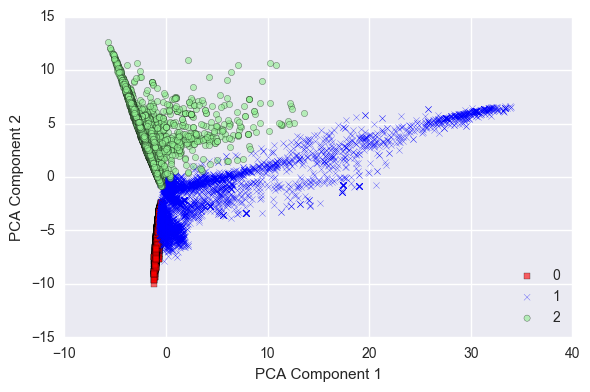

In [30]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_train['BUILDINGID']))])

for idx, cl in enumerate(np.unique(y_train['BUILDINGID'])):
        plt.scatter(x=X_train_pca[y_train.BUILDINGID== cl,0], 
                    y=X_train_pca[y_train.BUILDINGID== cl,1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='lower right')
plt.tight_layout()

The above plot illustrates how the buildingID are distributed across the top two PCA dimensions. Later, I explore the machine learning approaches for the building classification.

Remember PCA is an *unsupervised learning* technique for dimensionality reduction. So, it is quite possible the two top PCA components might not have explained our response variable well.

<p><a name = "floor-eda"></a></p>

### 2.2 Floor EDA

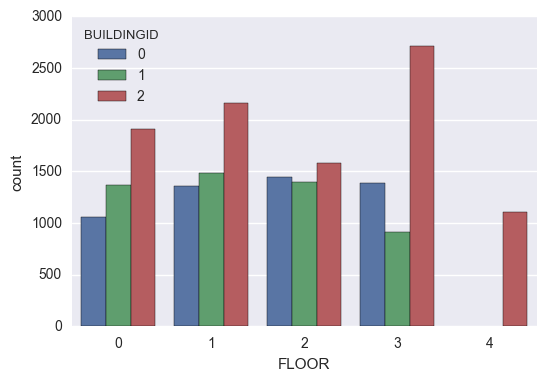

In [43]:
sns.countplot(x="FLOOR", hue="BUILDINGID", data=y_train,orient="v")

*Observations*:
    
1. Buildings 0 and 1 have 4 floors whereas Building 2 has 5 floors.

2. Expectedly, the samples from Building 2 are consistently the highest across all the floors.

<p><a name="Problem Formulation"></p>

<p><a name="problem-formulation"></a></p>

## 3. Problem Formulation

### 3.1 Error Metric

The overall goal of this project is to build models for accurate indoor localization. The mean positioning error expressed as the mean Euclidean distance between the real and estimated locations. **However, in multi-building, multi-floor environments as in our problem, just the positioning error due to Euclidean distance is not enough.** Wrong floor detection and wrong building detection are not desirable as the actual movement from the predicted location to the actual location might involve great displacement.

Therefore, we include penalty terms to the mean error equation to penalize failures in floor and building detection. This was introduced in the [2015 EvAAL-ETRI competition](http://content.iospress.com/articles/journal-of-ambient-intelligence-and-smart-environments/ais421). The cost function can be expressed as follows:

$positioning\_error(actual,predicted)= euclidean\_distance(actual,predicted) + penalty_{floor}*fail_{floor} + penalty_{building}*fail_{building}$

where $fail_{floor}$ and $fail_{building}$ indicate if the floor and building are incorrectly identified, $penalty_{floor}$ and $penalty_{building}$ are the penalty values applied for wrongful detection of floor and building respectively. The penalty values were set to 4 and 50 respectively in the third track of the competition ([Source](http://ieeexplore.ieee.org/document/7743679/)). Expecredly, the penalty for building detection failure is higher than that of floor detection failure. In this project, I utilize the same penalty term values for the error metric.

### 3.2 Machine Learning Methodology

The m

<p> <a name = "building-classification"></a></p>

## 4. Building Classification